# MUR Kerchunk  
### Author: Edward Armstrong 
#### 2022-04-25



### Objective:

Apply and adapt Kerchunk to the MUR SST dataset for fast time series analysis using xarray
* Adapted from 2022 ESIP Summmer Meeting Kerchunk tutorial by Lucas Sterzinger, https://github.com/lsterzinger/2022-esip-kerchunk-tutorial

_If Kerchunk is not >= 0.0.7 version, update with pip/conda: and **restart the kernel**_

In [3]:
import kerchunk
kerchunk.__version__

'0.0.8'

In [4]:
import xarray as xr
from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
import fsspec
from glob import glob
import requests

In [5]:
s3_cred_endpoint = {
    'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials',
    'lpdaac':'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials',
    'ornldaac':'https://data.ornldaac.earthdata.nasa.gov/s3credentials',
    'gesdisc':'https://data.gesdisc.earthdata.nasa.gov/s3credentials'
}

In [6]:
def get_temp_creds():
    temp_creds_url = s3_cred_endpoint['podaac']
    return requests.get(temp_creds_url).json()

In [7]:
temp_creds = get_temp_creds()
temp_creds

{'accessKeyId': 'xxxx',
 'secretAccessKey': 'xxxx',
 'sessionToken': 'xxxx',
 'expiration': '2022-10-12 00:30:03+00:00'}

## `fsspec` -- What is it?
* Provides unified interface to different filesystem types
* Local, cloud, http, dropbox, Google Drive, etc
    * All accessible with the same API

In [8]:
from fsspec.registry import known_implementations
known_implementations.keys()

dict_keys(['file', 'memory', 'dropbox', 'http', 'https', 'zip', 'tar', 'gcs', 'gs', 'gdrive', 'sftp', 'ssh', 'ftp', 'hdfs', 'arrow_hdfs', 'webhdfs', 's3', 's3a', 'wandb', 'oci', 'adl', 'abfs', 'az', 'cached', 'blockcache', 'filecache', 'simplecache', 'dask', 'dbfs', 'github', 'git', 'smb', 'jupyter', 'jlab', 'libarchive', 'reference', 'generic', 'oss', 'webdav'])

### Open a new filesystem, of type `s3` (Amazon Web Services storage)
This tells `fsspec` what type of storage system to use (AWS S3) and authenticate with credentials

In [9]:
fs = fsspec.filesystem('s3', anon=False, 
                    key=temp_creds['accessKeyId'],
                    secret=temp_creds['secretAccessKey'],
                    token=temp_creds['sessionToken'])

In [12]:
#s3path = 's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/2021121[0-5]*nc'
s3path = 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/202012*nc'

flist = fs.glob(s3path)

### Prepend `s3://` to the URLS

In [13]:
flist = ['s3://' + f for f in flist]
flist

['s3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20201201090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20201202090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20201203090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20201204090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20201205090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20201206090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20201207090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20201208090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',


## Example of creating a single kerchunk reference

In [14]:
u = flist[0]
u

's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20201201090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc'

In [15]:
with fsspec.open(u, mode="rb", anon=False,
                    key=temp_creds['accessKeyId'],
                    secret=temp_creds['secretAccessKey'],
                    token=temp_creds['sessionToken']) as infile:
                    single = SingleHdf5ToZarr(infile, u, inline_threshold=1000000).translate()

In [16]:
#single

## Create references for all files in `flist` and package to single output 

In [17]:
singles = []
for u in flist:
    with fsspec.open(u, mode="rb", anon=False, 
                    key=temp_creds['accessKeyId'],
                    secret=temp_creds['secretAccessKey'],
                    token=temp_creds['sessionToken']) as inf:
                    single = SingleHdf5ToZarr(inf, u, inline_threshold=1000000)
                    singles.append(single.translate())

In [18]:
mzz = MultiZarrToZarr(
    singles,
    remote_protocol="s3",
    remote_options={'anon': True},
    concat_dims=['time'],
    identical_dims=['lon', 'lat']
)

out = mzz.translate()

In [19]:
#out

## Read the entire array via xarray

In [20]:
import xarray as xr
ds = xr.open_dataset(
    "reference://", engine="zarr", 
    backend_kwargs={
        "storage_options": {
            "fo": out,
            "remote_protocol": "s3",
            "remote_options": {"anon": True}
        },
        "consolidated": False
    }
)

In [21]:
ds

<xarray.Dataset>
Dimensions:           (time: 31, lat: 720, lon: 1440)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time              (time) datetime64[ns] 2020-12-01T09:00:00 ... 2020-12-3...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    sst_anomaly       (time, lat, lon) float32 ...
Attributes: (12/54)
    Conventions:                CF-1.7, ACDD-1.3
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_institution:        Jet Propulsion Laboratory
    ...                         ...
    time_coverage_end:          20201201T210000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        20201130T210000Z
    title:                      Daily 0.25-degree MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

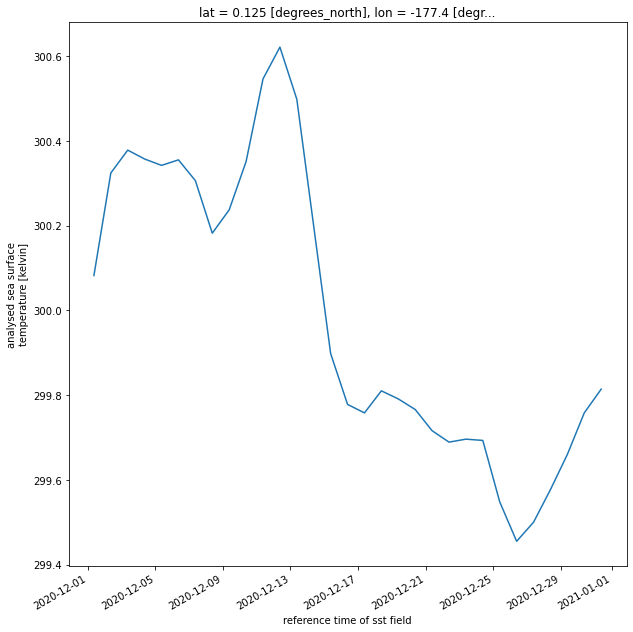

In [23]:
# Do some plotting
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ds.analysed_sst.isel(lon=10, lat=360).plot.line(x="time")